# Setup
The first part of the notebook is used to setup the libraries, import the data and familiarize myself with some basic questions about the data:
- format
- Total people
- how many, men, women
- general age statistics

After I have this information I will hopefully be able to ask better questions. 

##### Skip to the Questions seciton if you don't want to see the setup and inital data exploration.

In [1]:
#import important python Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# pull in the raw data and make sure in formatted correctly
titanic_data = pd.read_csv('titanic-data.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Basic Information about the data

In [3]:
print("There are {} passengers records in the dataset, {} of which survived giving a survival rate of {:.0%}".format(len(titanic_data),titanic_data['Survived'].sum(), titanic_data['Survived'].mean()))
print(titanic_data.groupby('Sex').size())
print(titanic_data.groupby(['Sex','Survived']).size())

print("for records with valid ages:")
valid_age_data = titanic_data[titanic_data['Age'].notnull()]
valid_age_data['Age'].describe()


There are 891 passengers records in the dataset, 342 of which survived giving a survival rate of 38%
Sex
female    314
male      577
dtype: int64
Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64
for records with valid ages:


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

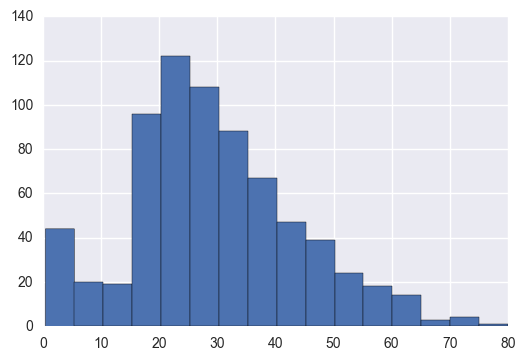

In [4]:
valid_age_data['Age'].hist(bins=16)

In [5]:
titanic_data.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [6]:
titanic_data.groupby('Pclass').size()

Pclass
1    216
2    184
3    491
dtype: int64

In [7]:
titanic_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

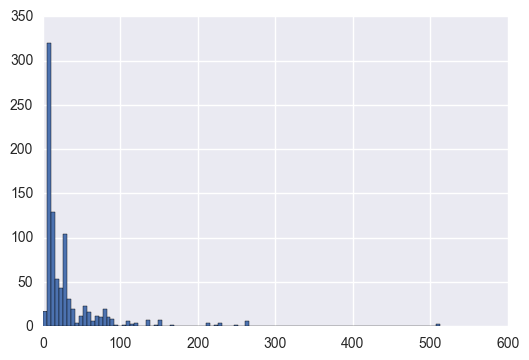

In [8]:
titanic_data['Fare'].hist(bins=100)

## Data Manipulation 

I need to do some clean up and categorization.
Since I will want to combine Fare, and age with other categorical data I will:
- convert age to 5 year increments (or unknown)
- convert fare to \$10 increments up to \$100 then \$100 to \$300 and over \$300

In [9]:

#####For the age calculation I will remove the nan values then do the corrcoef calculation
data = titanic_data  # Create a new var before I change it.
data_age = data[data['Age'].notnull()]
### a diction for storing the list of columns when i convert the categorial data
category_columns = {}

In [10]:

## Categorize age in 5 year increments
#### it's difficult to use a list comprehision or function here because of the nan values... so I'm goin to use a for loop
age_cat = []
for a in data['Age']:
    if np.isnan(a):
        age_cat.append('unknown')
    else:
        num =int((a//5) * 5)
        age_cat.append('age{}to{}'.format(num, num + 5))
        
age_tmp = pd.get_dummies(age_cat)
category_columns["Age"] = age_tmp.columns.values
data = pd.concat([data,age_tmp], axis=1)

fare_cat = []
for a in data['Fare']:
    if np.isnan(a):
        fare_cat.append('unknown')
    elif a >= 200:
        fare_cat.append('Fare200+')
    else:
        num =int((a//10) * 10)
        fare_cat.append('fare{}to{}'.format(num, num + 10))
fare_tmp = pd.get_dummies(fare_cat)
category_columns['Fare'] = fare_tmp.columns.values
data = pd.concat([data,fare_tmp], axis=1)


In [11]:
#modify the DataFrame to create a set of categorical columns out of colums using he pandas get dummies funcitons
#should not be used with age
for col in ["Pclass","Sex","SibSp","Parch","Embarked"]:
    data = pd.concat([data,pd.get_dummies(titanic_data[col], prefix=col)], axis=1)
    category_columns[col] = ["{}_{}".format(col,c) for c in data[col].unique()]




In [12]:
data[data['Sex_female'] ==1]['Survived'].mean()

0.7420382165605095

#### category_columns & calculate_status
The category_columns dictionary is used to hold groupings of categories to make it easier to pass them to the caluclate_stats function

The calculate_status function takes the data and and a 

In [13]:
category_columns

{'Age': array(['age0to5', 'age10to15', 'age15to20', 'age20to25', 'age25to30',
        'age30to35', 'age35to40', 'age40to45', 'age45to50', 'age50to55',
        'age55to60', 'age5to10', 'age60to65', 'age65to70', 'age70to75',
        'age80to85', 'unknown'], dtype=object),
 'Embarked': ['Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_nan'],
 'Fare': array(['Fare200+', 'fare0to10', 'fare100to110', 'fare10to20',
        'fare110to120', 'fare120to130', 'fare130to140', 'fare140to150',
        'fare150to160', 'fare160to170', 'fare20to30', 'fare30to40',
        'fare40to50', 'fare50to60', 'fare60to70', 'fare70to80',
        'fare80to90', 'fare90to100'], dtype=object),
 'Parch': ['Parch_0',
  'Parch_1',
  'Parch_2',
  'Parch_5',
  'Parch_3',
  'Parch_4',
  'Parch_6'],
 'Pclass': ['Pclass_3', 'Pclass_1', 'Pclass_2'],
 'Sex': ['Sex_male', 'Sex_female'],
 'SibSp': ['SibSp_1',
  'SibSp_0',
  'SibSp_3',
  'SibSp_4',
  'SibSp_2',
  'SibSp_5',
  'SibSp_8']}

In [14]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'age0to5', 'age10to15',
       'age15to20', 'age20to25', 'age25to30', 'age30to35', 'age35to40',
       'age40to45', 'age45to50', 'age50to55', 'age55to60', 'age5to10',
       'age60to65', 'age65to70', 'age70to75', 'age80to85', 'unknown',
       'Fare200+', 'fare0to10', 'fare100to110', 'fare10to20', 'fare110to120',
       'fare120to130', 'fare130to140', 'fare140to150', 'fare150to160',
       'fare160to170', 'fare20to30', 'fare30to40', 'fare40to50', 'fare50to60',
       'fare60to70', 'fare70to80', 'fare80to90', 'fare90to100', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
####Function to take a list of categories, combine them and find the survial rate and corrilation 
def calculate_stat(data, column):

    stat = pd.DataFrame(index = [column], columns = ["Count", "Survival Rate"])
    if column in data.columns:
        tmp = data[data[column] == 1]
        stat["Count"] = len(tmp)
        stat["Survival Rate"] = tmp["Survived"].mean()
    else:
        stat['Count'] = 0
        stat['Survival Rate'] = 0
    #return only groups that have at least one person who fell into it
    return stat[stat['Count'] >0]


def calculate_stats(data, cols):
    return pd.concat([calculate_stat(data, col) for col in cols]).sort_values("Survival Rate", ascending=False)
# This function will take 2 list of columns and create a new pandas array with the value 1 if the passenger has 1 in both columns
# this is used to combine categorical data like age and gender
def create_column_union(data, column_group1, column_group2):
    # create a list of the combined column names
    new_columns = pd.DataFrame()
    new_column_names = []
    for col1 in column_group1:
        for col2 in column_group2:
            tmp_col_name = "{}&{}".format(col1,col2)
            if not tmp_col_name in data.columns:
                new_columns[tmp_col_name] = np.bitwise_and(data[col1], data[col2])
                new_column_names.append(tmp_col_name)           
    return new_columns, new_column_names


In [16]:
new_data, names = create_column_union(data, category_columns["Sex"], category_columns["Pclass"])
category_columns["PclassGender"] = names
data = pd.concat([data,new_data], axis=1)
new_data, names = create_column_union(data, category_columns["Age"], category_columns["PclassGender"])
category_columns["PclassGenderAge"] = names
data = pd.concat([data,new_data], axis=1)

In [17]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,age80to85&Sex_male&Pclass_2,age80to85&Sex_female&Pclass_3,age80to85&Sex_female&Pclass_1,age80to85&Sex_female&Pclass_2,unknown&Sex_male&Pclass_3,unknown&Sex_male&Pclass_1,unknown&Sex_male&Pclass_2,unknown&Sex_female&Pclass_3,unknown&Sex_female&Pclass_1,unknown&Sex_female&Pclass_2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,0,0


In [18]:
calculate_stats(data, category_columns["PclassGender"])

,Count,Survival Rate
Sex_female&Pclass_1,94,0.968085
Sex_female&Pclass_2,76,0.921053
Sex_female&Pclass_3,144,0.500000
Sex_male&Pclass_1,122,0.368852
Sex_male&Pclass_2,108,0.157407
Sex_male&Pclass_3,347,0.135447


In [19]:
calculate_stats(data,category_columns['Embarked'])

,Count,Survival Rate
Embarked_C,168,0.553571
Embarked_Q,77,0.389610
Embarked_S,644,0.336957


In [20]:
calculate_stats(data, category_columns['Parch'] + category_columns['SibSp'])

,Count,Survival Rate
Parch_3,5,0.600000
Parch_1,118,0.550847
SibSp_1,209,0.535885
Parch_2,80,0.500000
SibSp_2,28,0.464286
SibSp_0,608,0.345395
Parch_0,678,0.343658
SibSp_3,16,0.250000
Parch_5,5,0.200000
SibSp_4,18,0.166667


In [21]:
calculate_stats(data, category_columns['PclassGenderAge'])

,Count,Survival Rate
unknown&Sex_female&Pclass_2,2,1.000000
age15to20&Sex_female&Pclass_1,12,1.000000
age0to5&Sex_male&Pclass_1,2,1.000000
age40to45&Sex_female&Pclass_1,7,1.000000
age30to35&Sex_female&Pclass_2,12,1.000000
age30to35&Sex_female&Pclass_1,11,1.000000
age45to50&Sex_female&Pclass_1,6,1.000000
age45to50&Sex_female&Pclass_2,3,1.000000
age50to55&Sex_female&Pclass_2,4,1.000000
age55to60&Sex_female&Pclass_1,4,1.000000


# Questions

The most obvious line of questions is around the survial rate of different demographics represented in the dataset, and this is the aspect of the data that I will be exploring. 

#### Question 1: What were the demographic with the highest and lowest survial rates?



In [22]:
age_pr = np.corrcoef(data_age['Survived'], data_age['Age'], rowvar=1).item(1)
print("The Correlation of Age to Survival is:{}.".format(age_pr))
fare_pr = np.corrcoef(data['Survived'], data['Fare'], rowvar=1).item(1)
print("The Correlation of Fare to Survival is:{}.".format(fare_pr))
SibSp_pr = np.corrcoef(data['Survived'], data['SibSp'], rowvar=1).item(1)
print("The Correlation of the number of Sibling/Spouses on board to Survival is:{}.".format(SibSp_pr))
Parch_pr = np.corrcoef(data['Survived'], data['Parch'], rowvar=1).item(1)
print("The Correlation of the number Parents/Children on board to Survival is:{}.".format(Parch_pr))

The Correlation of Age to Survival is:-0.07722109457217764.
The Correlation of Fare to Survival is:0.25730652238496227.
The Correlation of the number of Sibling/Spouses on board to Survival is:-0.03532249888573559.
The Correlation of the number Parents/Children on board to Survival is:0.08162940708348365.
